# GAFF verification
This notebook is to compare a P3HT polymer typed with antechamber to one typed using antefoyer and GAFF-foyer. The file P3HT_16_typed.mol2 was typed with antechamber. The untyped structure is in P3HT_16.mol2.

In [6]:
import numpy as np
import mbuild as mb
import parmed as pmd
import foyer
import hoomd
import warnings

warnings.simplefilter("ignore")

In [2]:
compound = mb.load("P3HT_16.mol2")

#pmd_structure = compound.to_parmed() # this step isn't necessary?
#compound.visualize().show()

In [3]:
# Load GAFF
#GAFF = foyer.forcefields.load_GAFF()

# Use foyer to parameterize
#parameterized_structure = GAFF.apply(pmd_structure, assert_dihedral_params=False)

In [4]:
# Load GAFF
GAFF = foyer.forcefields.load_GAFF()

# Use foyer to parameterize
parameterized_structure = GAFF.apply(compound, assert_dihedral_params=False)

/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/foyer/validator.py:132: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart definition(s)", ValidationWarning)
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<C1 pos=(-0.0279, 0.0362,-0.0536), 0 bonds, id: 4849349584>" is element: "C"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<S5 pos=(-0.0831, 0.1616, 0.0422), 0 bonds, id: 4849346384>" is element: "S"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<H6 pos=(-0.0942,-0.0386,-0.0966), 0 bonds, id: 4890771856>" is element: "H"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/foyer/forcefield.py:248: UserWarning: Parameters have not been assigned to all 

In [5]:
#[atom.type for atom in parameterized_structure.atoms]

In [6]:
# The typing doesn't get saved to the mbuild compound when loaded from a typed file,
# so reading the typed atoms from the file is a workaround
# the type will be stored in column 5

#typed_compound = mb.load("P3HT_16_typed.mol2")
#typed_structure= compound.to_parmed()

typed_atoms = []
read = False
with open("P3HT_16_typed.mol2", "r") as f:
    for i,line in enumerate(f.readlines()):
        if line[0] == "@" and not "ATOM" in line:
            read = False
        if read:
            typed_atoms.append(line.split())
        if line[0] == "@" and "ATOM" in line:
            read = True

In [7]:
# which atoms are different?
# looks like cc and cd, which we knew about.
diff_list = [
    (atom_antechamber[5], atom_foyer.type) for atom_antechamber, atom_foyer
    in zip(typed_atoms, parameterized_structure.atoms) 
    if atom_foyer.type != atom_antechamber[5]
]

print(set(diff_list))

{('cd', 'cc_r5'), ('cc', 'cc_r5')}


Types mostly verified, now to set up simulation.

In [5]:
# why doesn't this work?
import mbuild as mb
import foyer
import warnings

warnings.simplefilter("ignore")

compound = mb.load("P3HT_16.mol2")

# Load GAFF
GAFF = foyer.forcefields.load_GAFF()

# Use foyer to parameterize
parameterized_structure = GAFF.apply(compound, assert_dihedral_params=False)

typed_compound = mb.Compound()
typed_compound.from_parmed(parameterized_structure)
#print([p.name for p in typed_compound.particles()])

# this would be nice when we have large systems--type one compound.

In [9]:
# Instead we rename them manually
for atom_pmd, atom_mb in zip(parameterized_structure, compound):
    atom_mb.name = atom_pmd.type
#print(set([p.name for p in compound.particles()]))

In [10]:
# I am getting errors from filling the box, so I want to determine whether my positions
# have been scaled. The first bond happens to be a C-C single bond which on average is 
# about 1.54 A or 0.154 nm
first_bond = [b for b in compound.bonds()][0]
pmd_bond = parameterized_structure.bonds[0]
print(f"compound bond {np.linalg.norm(first_bond[0].pos-first_bond[1].pos):.4f}")
print(f"pmd bond {pmd_bond.measure():.4f}")
# Looks like units are in nm in mbuild (was the mol2 in nm?)
# but are scaled in parmed.

compound bond 0.1070
pmd bond 1.3772


In [12]:
gaff_colors = {
    "cc_r5": "brown",
    "ss": "yellow",
    "h4": "white",
    "ha": "tan",
    "c3": "grey",
    "hc": "black"
}
# why don't the colors work?

#compound = mb.load("P3HT_16.mol2")
#box = mb.Box([10,10,10])
#system_box = mb.packing.fill_box(compound, 10, box=box)
#system_box.visualize(color_scheme=gaff_colors).show()
#set([p.name for p in system_box.particles()])

## Simulation setup starts here

In [13]:
import numpy as np
import mbuild as mb
import parmed as pmd
import foyer
import hoomd
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import hoomd.md
import hoomd.group

In [14]:
compound = mb.load("P3HT_16.mol2")
box = mb.Box([10,10,10])
system_box = mb.packing.fill_box(compound, 10, box=box)

/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<C1 pos=(-0.0279, 0.0362,-0.0536), 0 bonds, id: 4538302608>" is element: "C"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<S5 pos=(-0.0831, 0.1616, 0.0422), 0 bonds, id: 4914460432>" is element: "S"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<H6 pos=(-0.0942,-0.0386,-0.0966), 0 bonds, id: 4914400336>" is element: "H"
  atom, element))


In [15]:
#system_box_pmd = system_box.to_parmed(box=box) # maybe this step is not necessary.
GAFF = foyer.forcefields.load_GAFF()
struc = GAFF.apply(system_box, assert_dihedral_params=False)

/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<C1 pos=( 8.1870, 8.1958, 9.1423), 0 bonds, id: 4916141776>" is element: "C"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<S5 pos=( 8.0780, 8.0936, 9.0673), 0 bonds, id: 4916141264>" is element: "S"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<H6 pos=( 8.1769, 8.3041, 9.1407), 0 bonds, id: 4916141968>" is element: "H"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/foyer/forcefield.py:248: UserWarning: Parameters have not been assigned to all proper dihedrals. Total system dihedrals: 11320, Parameterized dihedrals: 10680. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers

In [4]:
#struc.omm_angle_force()

In [5]:
create_hoomd_simulation(struc, r_cut=1.2, auto_scale=True)

_all = hoomd.group.all()
hoomd.md.integrate.mode_standard(dt=0.0001)
integrator = hoomd.md.integrate.nvt(group=_all, kT=1.0, tau=1)
hoomd.dump.gsd("start.gsd", period=None, group=_all, overwrite=True)
hoomd.dump.gsd("traj.gsd", period=1e4, group=_all, phase=0, overwrite=True)

hoomd.run(1e5)
hoomd.dump.gsd("out.gsd", period=None, group=_all, overwrite=True);

HOOMD-blue 2.9.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 02/04/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Lui, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 4020 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 3 exclusions             : 180
notice(2): Particles with 4 exclusions             : 2080
notice(2): Particles with 6 exclusions             : 180
notice(2): Particles with 7 exclusions             :

In [16]:
from utils.cg_utils import gsd_rdf
import matplotlib.pyplot as plt

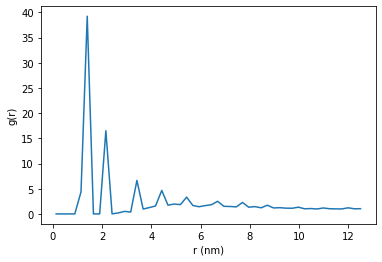

In [17]:
rdf = gsd_rdf("traj.gsd", "ss", "ss", start=-10)
plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.show()